In [9]:
import importlib
import os
import random
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.utils import make_grid

In [10]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [11]:
# Setting random seed for reproducibility
SEED = 123
set_seed(SEED)

# Experimental settings
DATASET = "CIFAR10"  # possible values: "CIFAR10" or "CIFAR100"
NUM_EPOCHS = 30
BATCH_SIZE = 50
LEARNING_RATE = 0.25
LR_GAMMA = 0.99
print(f"Training for {NUM_EPOCHS} epochs")

# Device to use for training and evaluation
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training for 30 epochs
Training on cpu


In [12]:
def load_datasets(
    num_clients: int,
    dataset: str = "CIFAR10",
    src: str = "./data",
    iid: bool = True,
    concentration: float = 1,
    use_augmentation: bool = True,
) -> Tuple[List[DataLoader], List[DataLoader], DataLoader]:
    if dataset not in ["CIFAR10", "CIFAR100"]:
        raise ValueError(
            "Unknown dataset! Admissible values are: 'CIFAR10' or 'CIFAR100'."
        )

    # Download and transform CIFAR dataset (train and test)
    augmentation = (
        [
            transforms.RandomCrop(24),
            transforms.RandomHorizontalFlip(),
        ]
        if use_augmentation
        else []
    )
    transform = [
        transforms.CenterCrop(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    trainset = getattr(torchvision.datasets, dataset)(
        src,
        train=True,
        download=True,
        transform=transforms.Compose([*augmentation, *transform]),
    )
    testset = getattr(torchvision.datasets, dataset)(
        src,
        train=False,
        download=True,
        transform=transforms.Compose([*transform]),
    )

    # Split training set into `num_clients` partitions to simulate different local datasets
    if not iid:
        targets = np.array(trainset.targets)
        idxs = np.array(range(len(targets)))
        dataset = [idxs, targets]
        train_partitions = non_iid_partitions(
            dataset,
            num_partitions=num_clients,
            concentration=concentration,
        )
        subsets = list(map(lambda p: Subset(trainset, p), train_partitions))
    else:
        partition_size = len(trainset) // num_clients
        lengths = [partition_size] * num_clients
        subsets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in subsets:
        len_val = len(ds) // 10  #  use 10% of client's data as validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(1, src="../../data/cifar10")

Files already downloaded and verified
Files already downloaded and verified


In [25]:
class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5, 1, 1)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs=1, lr=0.01, optimizer=None, verbose=True):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= (epoch + 1)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch, (images, labels) in enumerate(testloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= (batch + 1)
    accuracy = correct / total
    return loss, accuracy

In [28]:
# Create an instance of the model
NUM_CLASSES = len(np.unique(testloader.dataset.targets))
net = Net(NUM_CLASSES).to(DEVICE)
with torch.no_grad():
    assert net(torch.randn((3, 24, 24), device=DEVICE)).shape == torch.Size(
        [1, NUM_CLASSES]
    )

# Create optimizer
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_GAMMA)

# Print some stats about the model and the data
print("Model parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
print("Client's trainset size:", len(trainloaders[0].dataset))
print("Client's validation set size:", len(valloaders[0].dataset))
print("Server's testset size:", len(testloader.dataset))


Model parameters: 45626
Client's trainset size: 45000
Client's validation set size: 5000
Server's testset size: 10000


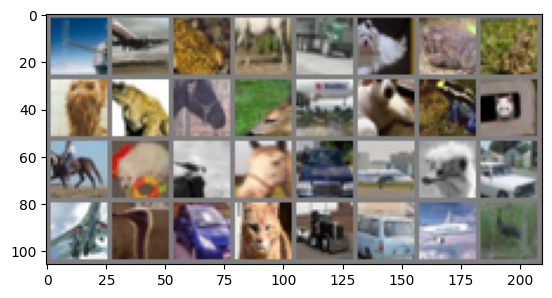

 ship plane  frog horse truck   dog  frog  frog
   cat  frog horse  deer plane   dog  frog   cat
 horse   dog  bird horse   car plane  bird   car
 plane  bird   car   cat truck   car plane  bird



In [29]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()


CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images, labels = next(iter(trainloaders[0]))
imshow(make_grid(images[:32]))
print(' '.join('%5s' % CLASSES[labels[j]] + ("\n" if (j + 1) % 8 == 0 else "") for j in range(32)))

In [31]:
trainloader = trainloaders[0]
valloader = valloaders[0]

for epoch in range(NUM_EPOCHS):
    train(net, trainloader, 1, optimizer=optimizer)
    loss, accuracy = test(net, valloader)
    lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}, lr {lr}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: train loss 1994.3228905200958, accuracy 0.15346666666666667
Epoch 1: validation loss 2.2427686882019042, accuracy 0.145, lr 0.2475
Epoch 1: train loss 2003.2892036437988, accuracy 0.1518
Epoch 2: validation loss 2.198861006498337, accuracy 0.165, lr 0.245025


KeyboardInterrupt: 